<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "6A"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/6A/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


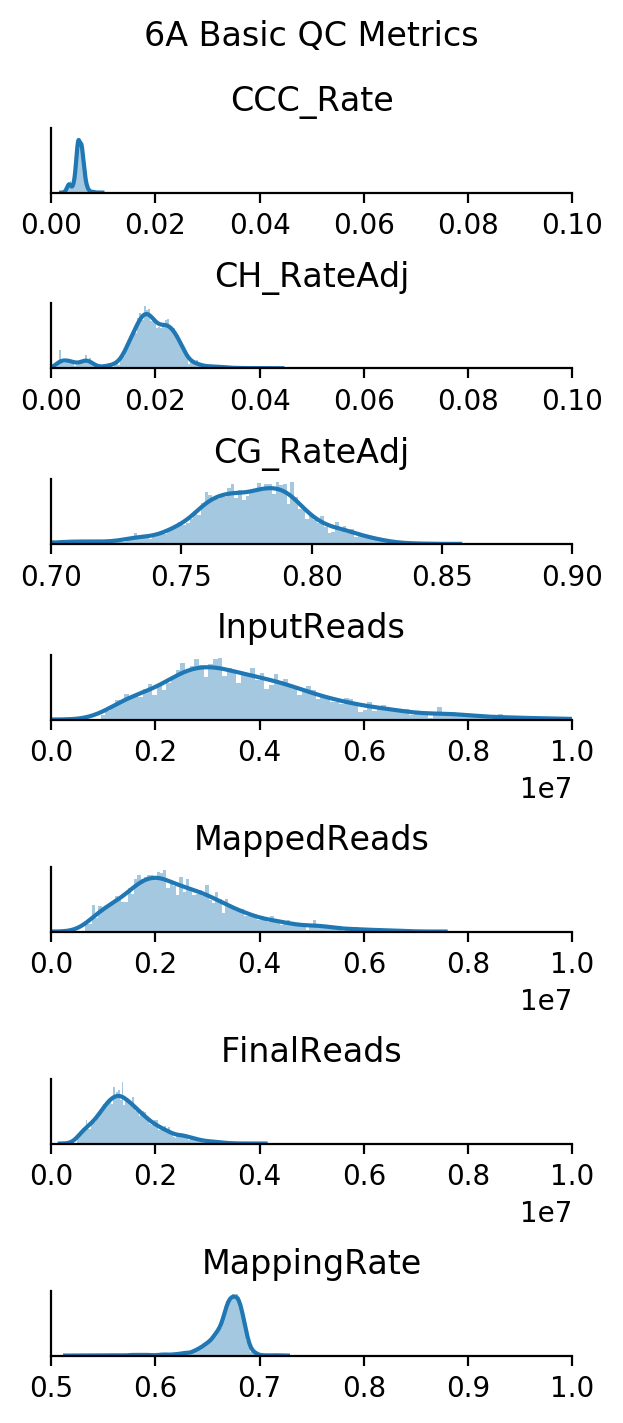

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

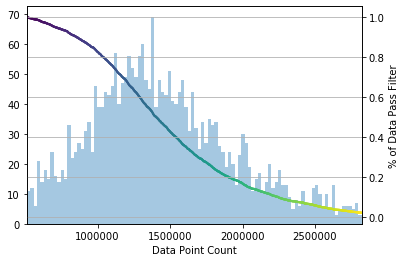

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2623/2623 (100.0%)
CG_RateAdj passed 2623/2623 (100.0%)
CH_RateAdj passed 2623/2623 (100.0%)
FinalReads passed 2623/2623 (100.0%)
MappingRate passed 2623/2623 (100.0%)
Overall passed 2623/2623 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190108 1315
190117 1308


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 323 84.1%
ad002 333 86.7%
ad004 336 87.5%
ad006 329 85.7%
ad007 320 83.3%
ad008 334 87.0%
ad010 322 83.9%
ad012 326 84.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
6A_M_0,/gale/raidix/rdx-4/mapping/6A/CEMBA190108-6A-1...,0.005676,0.802026,0.800896,0.030405,0.024870,698586.0,1411312,946992.0,6A,...,-24.726740,-2.475414,-60.538441,-3.329876,MGE-Sst Dock4,0.450793,-2.343611,-8.123089,-18.423179,True
6A_M_1,/gale/raidix/rdx-4/mapping/6A/CEMBA190108-6A-1...,0.005079,0.765228,0.764029,0.025810,0.020836,846254.0,1692682,1155872.0,6A,...,3.450626,-10.955466,-11.345191,26.383364,IT-L23 Tenm2,-3.644288,0.296368,-26.778432,2.566409,True
6A_M_10,/gale/raidix/rdx-4/mapping/6A/CEMBA190108-6A-1...,0.005946,0.792034,0.790790,0.030214,0.024413,1207708.0,2786542,1771658.0,6A,...,10.304777,-10.969389,20.668715,33.014381,IT-L5 Etv1,3.520144,4.113452,1.520240,4.884521,True
6A_M_100,/gale/raidix/rdx-4/mapping/6A/CEMBA190108-6A-1...,0.005488,0.764476,0.763177,0.025685,0.020308,808965.0,1677534,1106897.0,6A,...,3.762452,-11.365178,-9.909792,26.348097,IT-L23 Tenm2,-4.179482,0.734324,-26.995068,0.237544,True
6A_M_1000,/gale/raidix/rdx-4/mapping/6A/CEMBA190108-6A-3...,0.006019,0.797032,0.795803,0.028368,0.022485,710702.0,1963828,1266550.0,6A,...,10.825451,-10.401401,24.298527,37.064834,IT-L5 Etv1,1.312832,2.488272,20.487570,15.774916,True
6A_M_1001,/gale/raidix/rdx-4/mapping/6A/CEMBA190108-6A-3...,0.006366,0.790956,0.789617,0.031061,0.024854,1293160.0,3269552,2232024.0,6A,...,9.218153,-9.786183,20.752241,38.177191,IT-L5 Etv1,-0.287789,3.502183,26.628318,13.263796,True
6A_M_1002,/gale/raidix/rdx-4/mapping/6A/CEMBA190108-6A-3...,0.005037,0.753560,0.752312,0.023439,0.018495,1271139.0,3153580,2159349.0,6A,...,1.522033,-10.610307,-17.928512,29.687042,IT-L23 Tenm2,0.577908,0.272805,1.391332,22.967721,True
6A_M_1003,/gale/raidix/rdx-4/mapping/6A/CEMBA190108-6A-3...,0.005255,0.788546,0.787429,0.022689,0.017526,1356046.0,3409098,2334807.0,6A,...,13.618787,-5.445321,0.045646,-13.416284,IT-L6 Man1c1,-10.446301,-6.047751,10.839828,-16.340145,True
6A_M_1004,/gale/raidix/rdx-4/mapping/6A/CEMBA190108-6A-3...,0.005556,0.804333,0.803240,0.026693,0.021255,1575372.0,4010262,2728102.0,6A,...,25.257755,9.381888,-16.792551,-31.739348,CT-L6 Il1rap,-1.620457,-21.003225,-12.566931,-26.183816,True
6A_M_1005,/gale/raidix/rdx-4/mapping/6A/CEMBA190108-6A-3...,0.006615,0.814313,0.813077,0.032313,0.025869,1548103.0,3943558,2667785.0,6A,...,25.556532,10.637122,-15.154799,-36.229527,CT-L6 Megf9,1.598301,-20.136169,-12.762332,-34.843746,True
